# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

**Описание данных**
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose — цель получения кредита

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import pprint

from pymystem3 import Mystem
from collections import Counter

In [2]:
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Отключаем для удобства scientific notation:

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
df.tail(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
21515,1,-467.685,28,среднее,1,женат / замужем,0,F,сотрудник,1,109486.328,заняться образованием
21516,0,-914.391,42,высшее,0,женат / замужем,0,F,компаньон,0,322807.777,покупка своего жилья
21517,0,-404.679,42,высшее,0,гражданский брак,1,F,компаньон,0,178059.553,на покупку своего автомобиля
21518,0,373995.711,59,СРЕДНЕЕ,1,женат / замужем,0,F,пенсионер,0,153864.650,сделка с автомобилем
21519,1,-2351.432,37,ученая степень,4,в разводе,3,M,сотрудник,0,115949.040,покупка коммерческой недвижимости
21520,1,-4529.317,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862,операции с жильем
21521,0,343937.404,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.807,сделка с автомобилем
21522,1,-2113.347,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561,недвижимость
21523,3,-3112.482,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.051,на покупку своего автомобиля
21524,2,-1984.508,40,среднее,1,женат / замужем,0,F,сотрудник,0,82047.419,на покупку автомобиля


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Посмотрим какая доля пропусков:
(можно сразу прикинуть % даже не умножая на 100)

In [6]:
df.isna().mean()

children           0.000
days_employed      0.101
dob_years          0.000
education          0.000
education_id       0.000
family_status      0.000
family_status_id   0.000
gender             0.000
income_type        0.000
debt               0.000
total_income       0.101
purpose            0.000
dtype: float64

In [7]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000,19351.000,21525.000,21525.000,21525.000,21525.000,19351.000
mean,0.539,63046.498,43.293,0.817,0.973,0.081,167422.302
std,1.382,140827.312,12.575,0.548,1.420,0.273,102971.566
min,-1.000,-18388.950,0.000,0.000,0.000,0.000,20667.264
25%,0.000,-2747.424,33.000,1.000,0.000,0.000,103053.153
50%,0.000,-1203.370,42.000,1.000,0.000,0.000,145017.938
75%,1.000,-291.096,53.000,1.000,1.000,0.000,203435.068
max,20.000,401755.400,75.000,4.000,4.000,1.000,2265604.029


**Вывод**

В датасете 21525 строк и 12 столбцов. 
Проблемы, которые необходимо решить:
- некачественные названия в столбцах education и purpose  
- пропущены значения в столбцах days_employed и total_income. Нужно выяснить с чем это связано, существует ли закономерность в появлении пропусков, не случайно ли их возникновение в наборе данных. 
- присутствуют отрицательные значения в столбце days_employed, нужно заменить их на положительные. 
- неизвестна валюта месячного дохода
- в днях стажа и в доходе плавающая точка
- есть дублирующие признаки — избыточны образование и его идентификатор (такая же проблема у семейного положения)
- странное максимальное значение стажа, выяснить почему так могло получиться. Возможно данные стажа в данной таблице указаны не в днях?

## Шаг 2. Предобработка данных

### Обработка пропусков

Подсчитаем суммарное количество пропусков:

In [8]:
df.isnull().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Проверим уникальные значения возраста клиентов:

In [9]:
df['dob_years'].unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75])

Существует странный возраст 0, возможно эти клиенты просто не указали свой возраст. Проверим много ли клиентов с таким возрастом:

In [10]:
df['dob_years'].value_counts()

35    617
40    609
41    607
34    603
38    598
42    597
33    581
39    573
31    560
36    555
44    547
29    545
30    540
48    538
37    537
50    514
43    513
32    510
49    508
28    503
45    497
27    493
56    487
52    484
47    480
54    479
46    475
58    461
57    460
53    459
51    448
59    444
55    443
26    408
60    377
25    357
61    355
62    352
63    269
64    265
24    264
23    254
65    194
66    183
22    183
67    167
21    111
0     101
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: dob_years, dtype: int64

101 клиент, возможно, не указал свой возраст. В данном случае можем заменить эти пропуски на медианное значение:

In [11]:
years_median = df[df['dob_years'] != 0]['dob_years'].median()
df['dob_years'] = df['dob_years'].replace(0, years_median)

**Вывод**

1. Количество пропусков в столбцах days_employed и total_income совпадает, так что скорее всего никакой закономерности нет. Возможно, это сбой системы. В таком случае нужно вместо пропусков подставить медиану и среднее значение дохода и стажа в зависимости от возраста. 
2. Обнаружили пропущенные значения в графе возраст . Для улучшения качества исследования, заменим отсутствующие данные на медианные

### Замена типа данных

Проверим формат столбца количества детей:

In [12]:
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Присутствуют значения "-1" и "20" в столбце количества детей. "-1" заменим на 1, а "20" заменим медианным значением, так как мы не знаем как возникла ошибка: случайно ввели лишний 0 при вводе 2 или вместо 0 случайно поставили 20

In [13]:
df['children'] = df['children'].replace(-1, 1)
children_median = df[df['children'] != 20]['children'].median()
df['children'] = df['children'].replace(20, children_median)

In [14]:
df['children'].value_counts()

0    14225
1     4865
2     2055
3      330
4       41
5        9
Name: children, dtype: int64

Найдем среднее значение и медиану дохода и стажа в зависимости от возраста и исправим отрицательные показатели на положительные в стаже:

In [15]:
df['total_income'] = df['total_income'].fillna(df.groupby('dob_years')['total_income'].transform('median'))
df['days_employed'] = abs(df['days_employed'].fillna(df.groupby('dob_years')['days_employed'].transform('mean')))

In [16]:
df.isnull().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

Неудобно воспринимать информацию по трудовому стажу в днях, лучше пересчитать дни в года:

In [17]:
years_employed = round(df['days_employed'] / 365, 1)

Посмотрим на стаж теперь:

In [18]:
years_employed.describe()

count   21525.000
mean      183.106
std       371.385
min         0.100
25%         2.600
50%         6.200
75%        18.700
max      1100.700
Name: days_employed, dtype: float64

Теперь явно видно, что есть ошибка в трудовом стаже. Возможно, на самом деле это были не дни, а не часы?
Проверим нашу теорию, округлив результат до сотых: 

In [19]:
years_employed = round((df['days_employed'] /24)/ 365, 2)
years_employed.describe()

count   21525.000
mean        7.629
std        15.474
min         0.000
25%         0.110
50%         0.260
75%         0.780
max        45.860
Name: days_employed, dtype: float64

Вот теперь похоже на правду! Добавим новую колонку рядом со старой:

In [20]:
df.insert(2, 'years_employed', years_employed)

Дни переименуем в часы и приведем к целым значениям:

In [21]:
df = df.rename(columns={'days_employed': 'hours_employed',})
df['hours_employed']=df['hours_employed'].astype(int)

Посмотрим на доходы:

In [22]:
df['total_income'].value_counts()

155358.964    69
158350.077    67
148728.769    66
156145.372    65
159167.993    65
              ..
91169.615      1
59945.117      1
167791.985     1
227040.868     1
150014.129     1
Name: total_income, Length: 19380, dtype: int64

Смотреть на доходы с 6 знаками после запятой неудобно. В контексте задачи, точностью можно пожертвовать. Посмотрим на доходы, но сначала приведем к целым значениям:

In [23]:
df['total_income'] = df['total_income'].astype(int)

In [24]:
df.head()

,children,hours_employed,years_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,0.960,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,0.460,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,0.640,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,0.470,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,340266,38.840,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу


In [25]:
df['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

In [26]:
# Приведем столбец education к нижнему регистру
df['education'] = df['education'].str.lower()

In [27]:
df.head()

,children,hours_employed,years_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,0.960,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,0.460,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,0.640,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,0.470,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,340266,38.840,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу


**Вывод**

1. В столбце education присутствовали значения "-1" и "20". Мы заменили "-1" на 1, а "20" на медианное значением, так как мы не знаем как возникла ошибка: случайно ввели лишний 0 при вводе 2 или вместо 0 случайно поставили 20.
2. Заполним пропуски: Найдем среднее значение и медиану дохода и стажа в зависимости от возраста и исправим отрицательные показатели на положительные в стаже, это повысит качество данных, упростит обработку, но при этом незначительно скажется на результатах.
3. Приведем столбец education к нижнему регистру. 
4. Перессчитали трудовой стаж из дней в года, в ходе исследования выяснили, что изначально трудовой стаж считался не в днях, а в часах. Округлили значения до сотых.
5. Доходы привели к целым значениям для удобства восприятия информации. В контексте задачи такая детальная точность была не нужна. 

### Обработка дубликатов

In [28]:
df.duplicated().sum()

71

In [29]:
# Удалим дубли и сбросим индекс
df = df.drop_duplicates().reset_index(drop=True)

In [30]:
# Проверим удалились ли дубли
df.duplicated().sum()

0

In [31]:
df.head()

,children,hours_employed,years_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,0.960,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,0.460,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,0.640,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,0.470,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,340266,38.840,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу


**Вывод**

Обнаружился 71 дубликат. Возможно, это человеческий фактор. 

### Лемматизация

In [32]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

In [33]:
m = Mystem()
purpose = ' '.join(df['purpose'])

In [34]:
lemmas = m.lemmatize(purpose)
Counter(lemmas)

Counter({'покупка': 5897,
         ' ': 55023,
         'жилье': 4460,
         'приобретение': 461,
         'автомобиль': 4306,
         'дополнительный': 906,
         'образование': 4013,
         'сыграть': 765,
         'свадьба': 2324,
         'операция': 2604,
         'с': 2918,
         'на': 2222,
         'проведение': 768,
         'для': 1289,
         'семья': 638,
         'недвижимость': 6351,
         'коммерческий': 1311,
         'жилой': 1230,
         'строительство': 1878,
         'собственный': 635,
         'подержать': 853,
         'свой': 2230,
         'со': 627,
         'заниматься': 904,
         'сделка': 941,
         'получение': 1314,
         'высокий': 1374,
         'подержанный': 111,
         'профильный': 436,
         'сдача': 651,
         'ремонт': 607,
         '\n': 1})

**Вывод**

Выделим цели кредитов руками:
- Жилье
- Автомобиль
- Образование
- Свадьба 

### Категоризация данных

Многие уникальные значения цели кредита названы похожим образом. Создадим новую таблицу с исправленными категориями:

In [35]:
def df_purpose_grouped(row):
    purpose_grouped = row['purpose']
    if 'недвижим' in purpose_grouped or 'жиль' in purpose_grouped:
        return 'жилье'
    elif 'свадьб' in purpose_grouped:
        return 'свадьба'
    elif 'автомоб' in purpose_grouped:
        return 'автомобиль'
    elif 'образова' in purpose_grouped:
        return 'образование'
    return 'неизвестно'

In [36]:
df['purpose_category']=df.apply(df_purpose_grouped,axis=1)

In [37]:
# Проверяем что значений None не осталось
Counter(df['purpose_category'])

Counter({'жилье': 10811,
         'автомобиль': 4306,
         'образование': 4013,
         'свадьба': 2324})

In [38]:
# Проверяем результат в таблице
df.head()

,children,hours_employed,years_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category
0,1,8437,0.960,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,жилье
1,1,4024,0.460,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль
2,0,5623,0.640,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,жилье
3,3,4124,0.470,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование
4,0,340266,38.840,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба


Категоризируем колличество детей:

In [39]:
def df_children(row):
    children_grouped = row['children']
    if children_grouped == 0:
        return 'без детей'
    elif children_grouped <= 2:
        return '1-2 ребенка'
    elif children_grouped >= 3:
        return 'многодетные'

Создадим колонку с новыми данными:

In [40]:
children_grouped = df.apply(df_children,axis=1)
df.insert(1,'children_grouped', children_grouped )

In [41]:
df.head()

,children,children_grouped,hours_employed,years_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category
0,1,1-2 ребенка,8437,0.960,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,жилье
1,1,1-2 ребенка,4024,0.460,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль
2,0,без детей,5623,0.640,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,жилье
3,3,многодетные,4124,0.470,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование
4,0,без детей,340266,38.840,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба


Проверим формат столбца семейный статус:

In [42]:
df['family_status'].value_counts()

женат / замужем          12339
гражданский брак          4151
Не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

In [43]:
df['gender'].value_counts()

F      14174
M       7279
XNA        1
Name: gender, dtype: int64

Обнаружился неизвестный пол XNA. Cкорее всего это ошибка, но так как мы не знаем пол человека и не можем сделать предположений из данных, а также в расчетах использовать значение не будем, то оставляем его как есть.

In [44]:
df['income_type'].value_counts()

сотрудник          11084
компаньон           5078
пенсионер           3829
госслужащий         1457
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

С этим столбцом все впорядке. 

In [45]:
df['education'].value_counts()

среднее                15172
высшее                  5250
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

**Вывод**

1. Многие уникальные значения цели кредита названы похожим образом. Была создана новая таблица с исправленными категориями. В данной задаче это не понадобится, но эта категоризация, возможно, поможет другим аналитикам, изучающим влияние цели кредита на возврат денег во-время.
2. В столбце 'gender' обнаружился неизвестный пол XNA. Cкорее всего это ошибка, но так как мы не знаем пол человека и не можем сделать предположений из данных или из расчетов, то использовать значение не будем, оставляем его как есть.
3. Катеогризировали количество детей: создали новую колонку, куда добавили семьи без детей, с 1-2 детьми и многодетных.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [46]:
df.groupby('children_grouped')['debt'].agg(['count','sum','mean'])

,count,sum,mean
children_grouped,,,
1-2 ребенка,6907,639,0.093
без детей,14167,1071,0.076
многодетные,380,31,0.082


**Вывод**

- Наибольшее количество кредитов берут семьи без детей, но при этом они, как правило, реже просрачивают оплату по кредиту, чем люди с детьми. 
- Хуже всего отдают кредиты люди, у которых 1-2 ребенка.
- Многодетные чаще выплачивают кредит во-время, чем люди с 1-2 детьми. 

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [47]:
df.groupby('family_status')['debt'].agg(['count','sum','mean'])

,count,sum,mean
family_status,,,
Не женат / не замужем,2810,274,0.098
в разводе,1195,85,0.071
вдовец / вдова,959,63,0.066
гражданский брак,4151,388,0.093
женат / замужем,12339,931,0.075


**Вывод**

Есть очевидная зависимость от семейного положения:
- Люди не в браке и не бывавшие в браке берут больше всего кредитов и хуже всего выплачивают их. 
- Вдовы/вдовцы имеют наименьший процент невозвратов кредитов

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Для удобства выполним целочисленное деление дохода на 50000, тем самым разбив людей на категории каждые 50000 дохода. Начиная с id 10 (зп >= 500000), выборка людей становится нерепрезентативной, поэтому объединяем людей с доходом => 500000 в одну категорию (id = 10). Для этого добавим в функцию условие:

In [48]:
def total_income_category(value):
    if value >= 500000:
        return 10
    else:
        value = value // 50000
        return value

In [49]:
df['total_income_id'] = df['total_income'].apply(total_income_category)

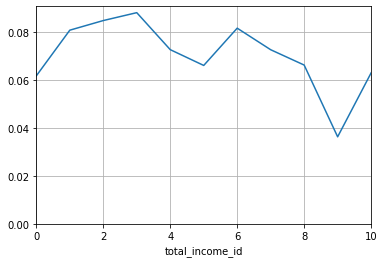

In [50]:
df.groupby('total_income_id')['debt'].mean().plot(ylim=0, grid=True)

Из графика очевидно, что чем больше доход, тем меньше задолженностью по кредиту. Проверим нашу гипотезу:

In [51]:
df['total_income'].describe()

count     21454.000
mean     165271.070
std       98080.888
min       20667.000
25%      107515.500
50%      146499.500
75%      195813.250
max     2265604.000
Name: total_income, dtype: float64

Посмотрим распредение:

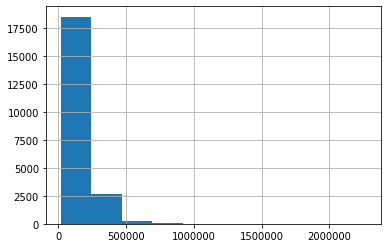

In [52]:
df['total_income'].hist()

In [53]:
quantille_group = ['25', '50', '75', 'max']

In [54]:
df['income_group']=pd.qcut(df['total_income'],q=[0, 1/4, 2/4, 3/4, 1],labels=quantille_group)

In [55]:
df.groupby('income_group')['debt'].agg(['count','sum','mean'])

,count,sum,mean
income_group,,,
25,5364,427,0.080
50,5363,455,0.085
75,5363,476,0.089
max,5364,383,0.071


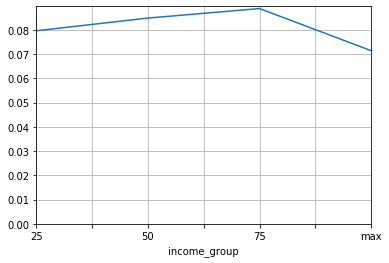

In [56]:
df.groupby('income_group')['debt'].mean().plot(ylim=0, grid=True)

Наша теория подтвердилась

**Вывод**

Проанализировав данные, стало очевидно, что с увеличением дохода растет и задолженность по кредиту, и при доходе выше среднего достигает своих максимальных значений. При этом далее с увеличением дохода задолженность начинает уменьшаться и, как очевидно из графика, что у людей с наибольшим доходом наименьшая задолженность по кредиту.

- Как разные цели кредита влияют на его возврат в срок?

In [ ]:
df.groupby('purpose_category')['debt'].agg(['count','sum','mean'])

**Вывод**

- наиболее погашаемые кредиты  на жильё (примерно одинаково с кредитами на свадьбу)
- просрочка чаще всего возникает у кредитов на автомобили и образование

## Шаг 4. Общий вывод

- Наибольшее количество кредитов берут семьи без детей, но при этом они, как правило, реже просрачивают оплату по кредиту, чем люди с детьми. Хуже всего отдают кредиты люди, у которых 1-2 ребенка. Многодетные чаще выплачивают кредит во-время, чем люди с 1-2 детьми. 
- Есть очевидная зависимость от семейного положения.Вдовцы и разведенные хуже всего выплачивают кредит. Очевидно, что это связано с финансовыми трудностями после развода или потери супруга/супруги. Люди не в браке и не бывавшие в браке имеют наименьший процент невозвратов, практически такой же как и люди в гражданском браке.
- Наименьшая задолженность по кредиту у людей с наибольшим доходом. При этом самая большая задолженность у группы с доходом ниже среднего.
- При этом наиболее погашаемые кредиты  на жильё (примерно одинаково с кредитами на свадьбу), а просроченные платежи чаще всего возникают у кредитов на автомобили и образование.